In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_auc_score,roc_curve
from matplotlib import cm

In [2]:
# Reading the CSV file
obesity_df = pd.read_csv('ObesityDataSet_raw_and_data_sinthetic.csv')  
# Filter real data from obesity_df
obesity_df = obesity_df[:498]

In [3]:
# Rename columns
obesity_df.rename(columns={'NObeyesdad': 'obese', 
                           'Gender':'gender',
                           'Age':'age',
                           'Weight': 'weight',
                           'family_history_with_overweight': 'family_history',
                           'FAF':'physical_activity',
                           'NCP':'main_meals_daily',
                           'SCC':'calories_monitoring',
                           'FAVC':'eat_frequent_high_calorie',
                           'CALC':'drink_alcohol'}, inplace=True)


In [4]:
# Encoding the Yes/No column
obesity_df['family_history']             = obesity_df['family_history'].map({'yes': 1, 'no': 0})
obesity_df['calories_monitoring']        = obesity_df['calories_monitoring'].map({'yes': 1, 'no': 0})
obesity_df['eat_frequent_high_calorie']  = obesity_df['eat_frequent_high_calorie'].map({'yes': 1, 'no': 0})
obesity_df['gender']                     = obesity_df['gender'].map({'Female': 1, 'Male': 0})
obesity_df['drink_alcohol']              = obesity_df['drink_alcohol'].map({'no':0, 'Sometimes':1, 'Frequently':1, 'Always':1})


In [5]:
# Binary grouping obese and non-obese
obesity_df['obese'] = obesity_df['obese'].map({'Normal_Weight': 0, 'Overweight_Level_I': 0,
                                               'Overweight_Level_II':1,'Obesity_Type_I': 1,
                                               'Insufficient_Weight': 0, 'Obesity_Type_II': 1,
                                               'Obesity_Type_III': 1})

In [6]:
# Identify explanatory variables
dfs = [obesity_df['gender'], obesity_df['age'], obesity_df['weight'], obesity_df['family_history'],
        obesity_df['physical_activity'], obesity_df['drink_alcohol']]

In [7]:
# Format column-wise
X = pd.concat(dfs, join='outer', axis=1)
# Add constant term
X = sm.add_constant(X)
# Identify response variable
y = obesity_df['obese']


In [8]:
# Calculate VIF for each independent variable to check multicollinearity.
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in np.arange(2,X.shape[1])]
vif["features"] = X.columns[2:]

if (vif["VIF Factor"] > 10).any(): 
    print('Multicollinearity in the features.')
else:
    print('Features are free of multicollinearity.')

Features are free of multicollinearity.


In [9]:
# Split the obesity_dfset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Initialize and fit the logistic regression model
model = sm.Logit(y_train, X_train).fit()
print(model.summary())

# Make predictions
predictions = model.predict(X_test)

# Calculate AUC (Area Under the ROC Curve)
auc_score = roc_auc_score(y_test, predictions)
print(f'Area Under the ROC Curve (AUC): {auc_score:0.3f}')

Optimization terminated successfully.
         Current function value: 0.182852
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                  obese   No. Observations:                  398
Model:                          Logit   Df Residuals:                      391
Method:                           MLE   Df Model:                            6
Date:                Mon, 26 Feb 2024   Pseudo R-squ.:                  0.6707
Time:                        10:33:52   Log-Likelihood:                -72.775
converged:                       True   LL-Null:                       -221.02
Covariance Type:            nonrobust   LLR p-value:                 4.619e-61
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -22.6793      2.732     -8.300      0.000     -28.035     -17.324
gender  

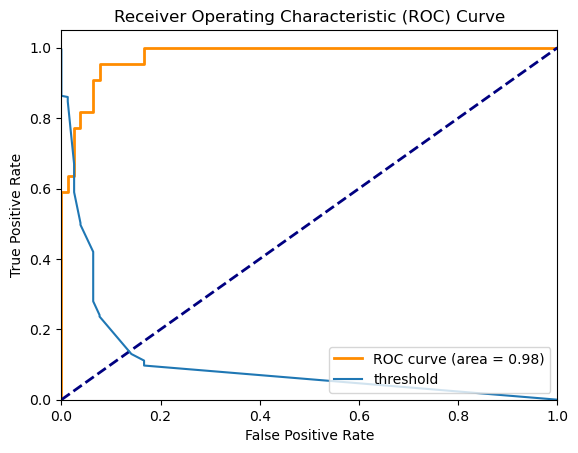

In [10]:
# Calculate false posive rate, true positive rate and threshold 
fpr, tpr, thresholds  = roc_curve(y_test, predictions)
# Plot ROC curve and threshold
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.plot(fpr, thresholds, label='threshold')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [11]:
# Set the threshold
prediction_threshold = 0.6
# Calculate the absolute difference between each threshold and the target value (0.6)
absolute_differences = np.abs(thresholds - prediction_threshold)
# Find the index of the smallest difference
closest_index = np.argmin(absolute_differences)

print(f"True Positive Rate: {tpr[closest_index]:0.3f}, False Positive Rate: {fpr[closest_index]:0.3f}")

# Map the probability to binary response
predictions_binary = predictions.apply(lambda x: 1 if x > prediction_threshold else 0)

True Positive Rate: 0.773, False Positive Rate: 0.026


Confusion Matrix:
[[76  2]
 [ 6 16]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95        78
           1       0.89      0.73      0.80        22

    accuracy                           0.92       100
   macro avg       0.91      0.85      0.88       100
weighted avg       0.92      0.92      0.92       100



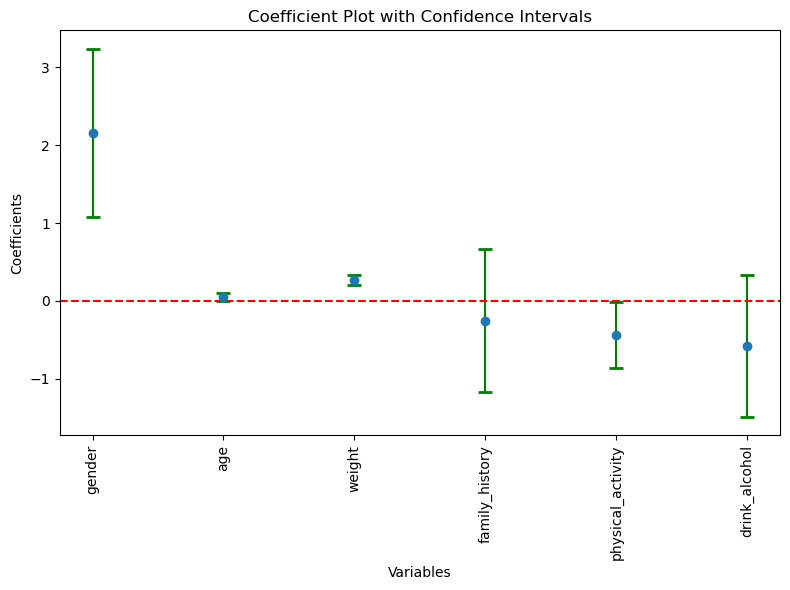

In [12]:
# Evaluate the model

# Compute confusion matrix to evaluate the accuracy of a classification.
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions_binary))

print("\nClassification Report:")
print(classification_report(y_test, predictions_binary))

coefficients = model.params
conf_int = model.conf_int()

# Creating a DataFrame for coefficients and confidence intervals
df_coeffs = pd.DataFrame({'coef': coefficients.values[1:], 'lower': conf_int.iloc[1:, 0], 'upper': conf_int.iloc[1:, 1]})
df_coeffs['variables'] = coefficients.index[1:]

# Plot errorbar 
plt.figure(figsize=(8, 6))
# errorbar to represent error margins or confidence intervals around a measurement. 
plt.errorbar(df_coeffs['variables'], df_coeffs['coef'], 
              yerr=[df_coeffs['coef'] - df_coeffs['lower'], df_coeffs['upper'] - df_coeffs['coef']], 
              fmt='o', ecolor='g', capthick=2, capsize=5)

plt.axhline(y=0, linestyle='--', color='red')
plt.xticks(rotation=90)
plt.title('Coefficient Plot with Confidence Intervals')
plt.ylabel('Coefficients')
plt.xlabel('Variables')
plt.tight_layout()